In [1]:
import sqlite3
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load the embedding data from the unshuffled sequences
# ids are in ruseq.txt
conn = sqlite3.connect('../uniref90-10pm.db')
c = conn.cursor()

# get the embeddings
embeddings_unshuff = []
with open('ruseq10000.txt') as f:
    keys = f.read().splitlines()

for key in keys:
    c.execute('SELECT embedding FROM uniref90 WHERE name = ?', (key,))
    embedding = c.fetchone()[0]
    if np.frombuffer(embedding, dtype=np.float16).shape[0] != 1024:
        embeddings_unshuff.append(np.frombuffer(embedding, dtype=np.float32))
    else:
        embeddings_unshuff.append(np.frombuffer(embedding, dtype=np.float16))

conn.close()

In [3]:
embeddings_unshuff = np.array(embeddings_unshuff)

In [4]:
# load the shuffled sequences
# embedding data is in rss.h5

embeddings_shuff = []

with h5py.File('rss10000.h5', 'r') as f:
    for key in f.keys():
        embeddings_shuff.append(f[key][:])

print(np.array(embeddings_shuff).shape)
embeddings_shuff = np.array(embeddings_shuff)

(10000, 1024)


In [5]:
import pandas as pd

# read third party embeddings from the tsv file
df = pd.read_csv('../rg/sfiltered_nonredundant.tsv', sep='\t')
df1 = pd.read_csv('../rg/filtered_nonredundant.tsv', sep='\t')

# get the euclid sim and cosine sim from the columns
# euclid_sim = df['embdd_eucld'].values
cos_sim = df['embdd_cos'].values
# euclid_sim1 = df1['embdd_eucld'].values
cos_sim1 = df1['embdd_cos'].values

In [6]:
# plot the norms of the embeddings on a histogram and a boxplot on the same plot

# fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plt.suptitle('Norm of embeddings, unshuffled vs shuffled')
# ax[0].hist(np.linalg.norm(embeddings_unshuff, axis=1), bins=100, alpha=0.5, label='UniRef90')
# ax[0].hist(np.linalg.norm(embeddings_shuff, axis=1), bins=100, alpha=0.5, label='shuffled')
# ax[0].set_title('Histogram of norms')
# ax[0].set_ylabel('Frequency')
# ax[0].set_xlabel('Norm')
# ax[0].legend()

# ax[1].boxplot([np.linalg.norm(embeddings_unshuff, axis=1), np.linalg.norm(embeddings_shuff, axis=1)], labels=['UniRef90', 'shuffled'])
# ax[1].set_title('Boxplot of norms')
# ax[1].set_ylabel('Norm')
# ax[1].set_xlabel('Dataset')

# plt.show()

In [7]:
# cosine similarity
# from sklearn.metrics.pairwise import cosine_similarity as cosine
import numpy as np
from numpy.linalg import norm
import tqdm

# unshuff - unshuff
sims_unshuff1 = []
sims_shuff1 = []
index = []
for i in tqdm.tqdm(range(embeddings_unshuff.shape[0]), total=embeddings_unshuff.shape[0]):
    for j in range(i+1, embeddings_unshuff.shape[0]):
        index.append((i, j))
        sims_unshuff1.append(np.dot(embeddings_unshuff[i], embeddings_unshuff[j]) / (norm(embeddings_unshuff[i]) * norm(embeddings_unshuff[j])))
        sims_shuff1.append(np.dot(embeddings_unshuff[i], embeddings_shuff[j]) / (norm(embeddings_unshuff[i]) * norm(embeddings_shuff[j])))
        

100%|██████████| 10000/10000 [17:53<00:00,  9.31it/s]  


In [17]:
# find the cutoff where in the total data above the cutoff is 95% of the unshuffle - unshuff similarity and at most 5% of the unshuff - shuff similarity
# sort the similarities
sims_unshuff1 = np.array(sims_unshuff1)
sims_shuff1 = np.array(sims_shuff1)

cutoffs = np.linspace(0,1,100)
thresholds = []
real_real = []
realp = []
shufp = []
real_shuff = []
totals = []
for c in cutoffs:
    su = np.sum(sims_unshuff1 >= c)
    ss = np.sum(sims_shuff1 >= c)
    total = su + ss
    real_real.append(su)
    real_shuff.append(ss)
    totals.append(total)
    realp.append(su / total)
    shufp.append(ss / total)


C:\Users\mackm\AppData\Local\Temp\ipykernel_9856\323792493.py:20: RuntimeWarning: invalid value encountered in scalar divide
  realp.append(su / total)
C:\Users\mackm\AppData\Local\Temp\ipykernel_9856\323792493.py:21: RuntimeWarning: invalid value encountered in scalar divide
  shufp.append(ss / total)


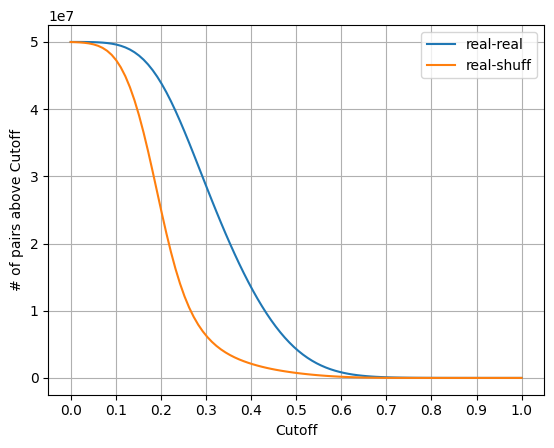

In [23]:
plt.plot(cutoffs, real_real, label='real-real')
plt.plot(cutoffs, real_shuff, label='real-shuff')
plt.ylabel("# of pairs above Cutoff")
plt.xlabel("Cutoff")
plt.xticks(np.linspace(0, 1, 11))
plt.grid(True)
plt.legend()
plt.show()

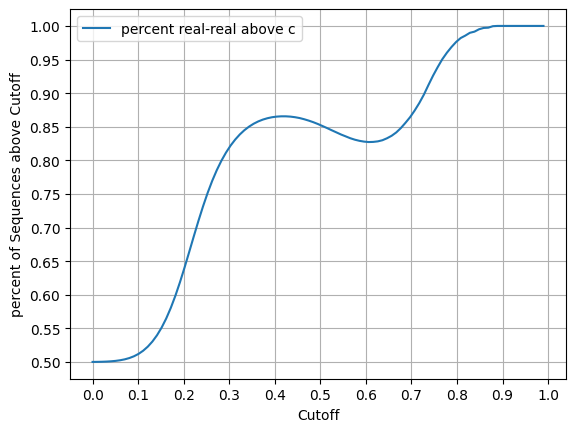

In [22]:
plt.plot(cutoffs, realp, label="percent real-real above c")
plt.ylabel("percent of Sequences above Cutoff")
plt.xlabel("Cutoff")
plt.grid(True)
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0.5, 1, 11))
plt.legend()
plt.show()

In [11]:
# find the cutoff by trying a random value first then adjusting
cutoffs = []
threshold = [0.05]
real_real = []
real_shuff = []
totals = []
for t in threshold:
    cutoff = 0
    while True:
        total = np.sum(sims_unshuff1 >= cutoff) + np.sum(sims_shuff1 >= cutoff)
        if np.sum(sims_unshuff1 >= cutoff) / total >= (1 - t) and np.sum(sims_shuff1 >= cutoff) / total <= t:
            cutoffs.append(cutoff)
            real_real.append(np.sum(sims_unshuff1 >= cutoff) / total)
            real_shuff.append(np.sum(sims_shuff1 >= cutoff) / total)
            totals.append(total)
            break
        else:
            cutoff += 0.01
print(real_real)
print(cutoffs)

[0.9516472330186934]
[0.7700000000000005]


In [12]:
index = np.array(index)
kept = sims_unshuff1 >= cutoffs[0]
kept_indeces = index[kept]
unique_elements, counts = np.unique(kept_indeces, return_counts=True)
element_counts = dict(zip(unique_elements, counts))


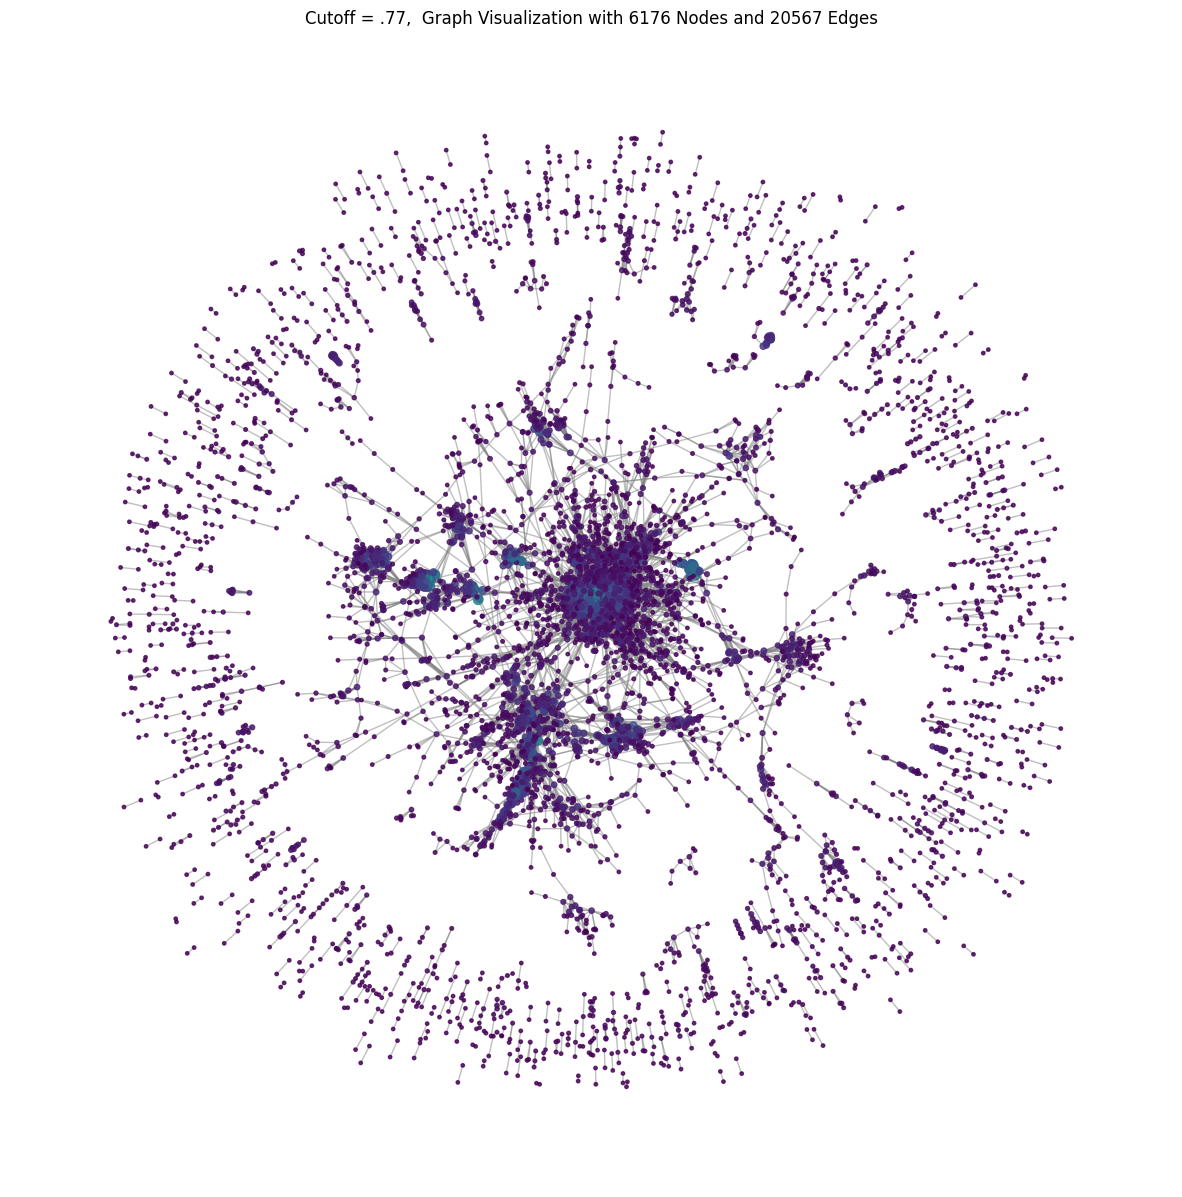

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from(kept_indeces.tolist())

# Force-directed layout for better spacing
pos = nx.spring_layout(G, seed=42, k = 0.02)

# Node size based on degree (scaled down for large graph)
degree = dict(G.degree())
node_size = [5 + degree[node] for node in G.nodes()]  # Base size is 5, scaling by degree

# Node color based on degree (to highlight highly connected nodes)
node_color = [5 + degree[node] for node in G.nodes()]

# Plot the graph
plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_size,
    node_color=node_color,
    cmap=plt.cm.viridis,
    alpha=0.8  # Slight transparency
)

nx.draw_networkx_edges(
    G,
    pos,
    edge_color="gray",
    alpha=0.5  # More transparency for edges
)

plt.title("Cutoff = .77,  Graph Visualization with {} Nodes and {} Edges".format(len(unique_elements), np.sum(kept)))
plt.axis("off")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

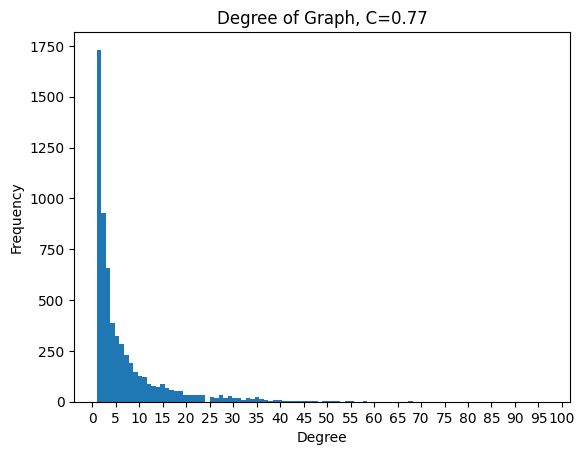

In [14]:
plt.hist(degree.values(), bins=100)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree of Graph, C=0.77")
plt.xticks(np.arange(0, max(counts) + 5, 5))
plt.show

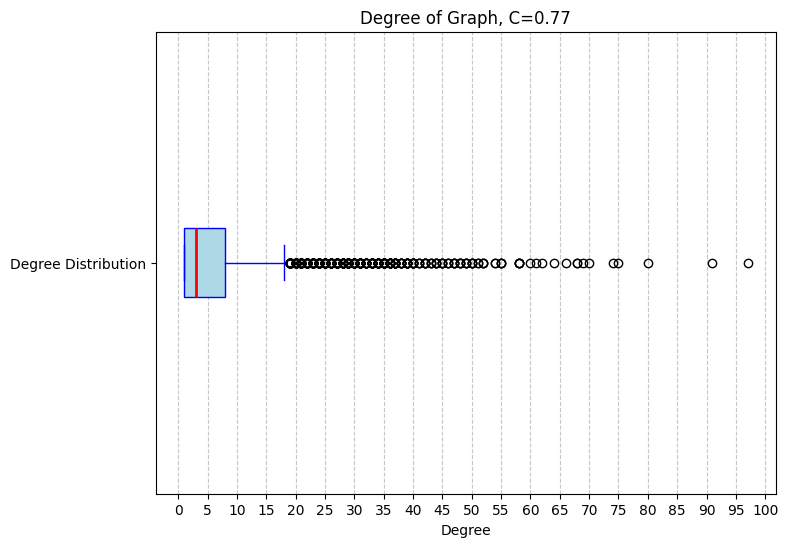

In [32]:
plt.figure(figsize=(8, 6))
plt.boxplot(degree.values(), vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            medianprops=dict(color='red', linewidth=2))

plt.xlabel("Degree")
plt.title("Degree of Graph, C=0.77")

# Setting yticks appropriately for a single horizontal boxplot
plt.yticks([1], ["Degree Distribution"])
plt.xticks(np.arange(0, max(degree.values()) + 5, 5))

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

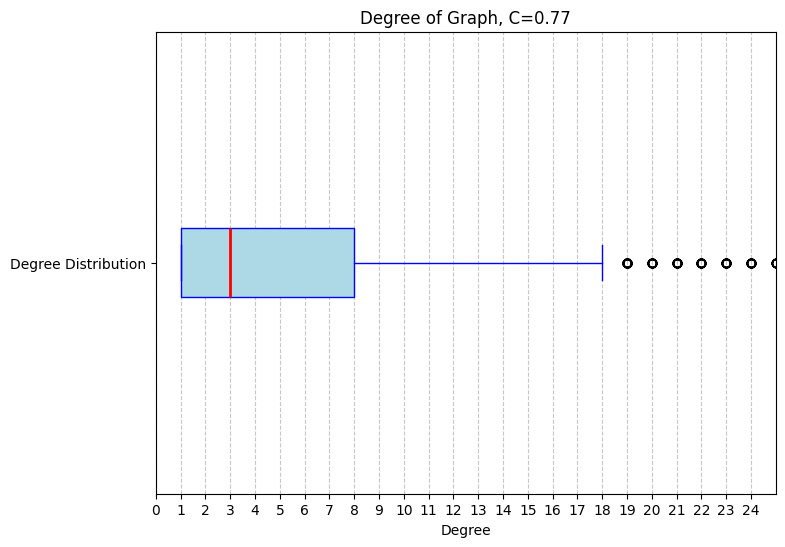

In [31]:
plt.figure(figsize=(8, 6))
plt.boxplot(degree.values(), vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='blue'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            medianprops=dict(color='red', linewidth=2))

plt.xlabel("Degree")
plt.title("Degree of Graph, C=0.77")

# Limiting x-axis to focus on main distribution (assuming main distribution < 25)
plt.xlim(0, 25)
plt.xticks(np.arange(0, 25, 1))

# Y-axis label for clarity
plt.yticks([1], ["Degree Distribution"])

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

In [36]:
np.set_printoptions(precision=3)
print(threshold)
print(cutoffs)
print(real_real)
print(real_shuff)
print(totals)
print(sims_shuff1.shape[0] + sims_unshuff1.shape[0])
print(np.array(totals) / (sims_shuff1.shape[0] + sims_unshuff1.shape[0]))

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
[0.7700000000000005, 0.7300000000000004, 0.35000000000000014, 0.2900000000000001, 0.26000000000000006, 0.23000000000000007]
[0.9516472330186934, 0.9011633166283719, 0.8530352941823471, 0.8082371945501399, 0.76497554773909, 0.7046002972939334]
[0.04835276698130668, 0.0988366833716281, 0.14696470581765292, 0.19176280544986013, 0.2350244522609099, 0.29539970270606664]
[21612, 55273, 24002171, 37532633, 46295719, 56891171]
99990000
[2.161e-04 5.528e-04 2.400e-01 3.754e-01 4.630e-01 5.690e-01]


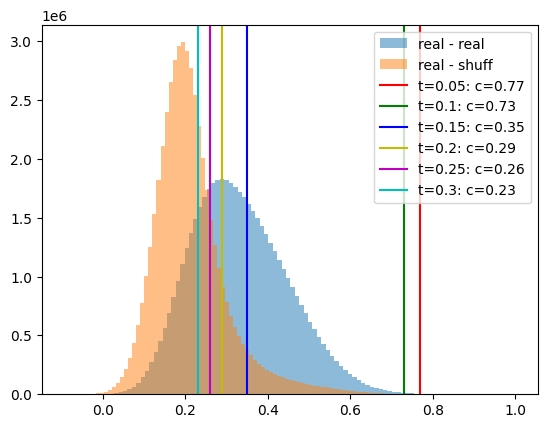

In [35]:
plt.hist(sims_unshuff1, bins=100, alpha=0.5, label='real - real')
plt.hist(sims_shuff1, bins=100, alpha=0.5, label='real - shuff')
for i, c in enumerate(cutoffs):
    cutoff = round(c, 2)
    color = ['r', 'g', 'b', 'y', 'm', 'c']
    plt.axvline(c, color=color[i], label=f't={threshold[i]}: c={cutoff}')
plt.legend()
plt.show()

TypeError: 'Axes' object is not subscriptable

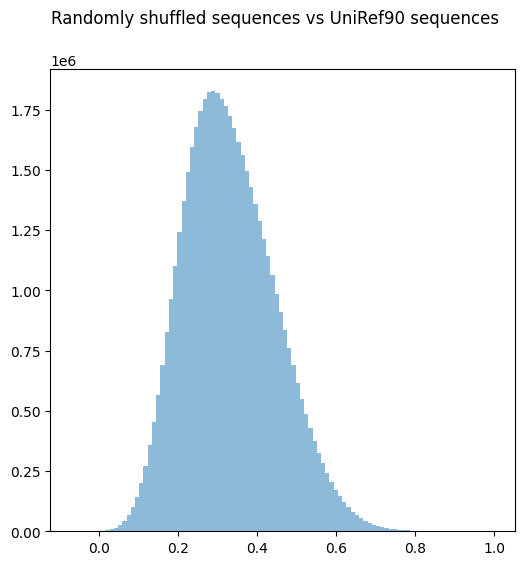

In [ ]:
# fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Create 1x3 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create 1x3 subplots

fig.suptitle('Randomly shuffled sequences vs UniRef90 sequences')

# axs[0].boxplot([sims_shuff, sims_unshuff, euclid_sim, euclid_sim1], labels=['unshuff - shuff', 'unshuff - unshuff', 'praba-same-F', 'praba-diff-F'])
# axs[0].set_title('Euclidean Similarity')
# axs[0].set_ylabel('Similarity')

# axs[1].hist(sims_unshuff, bins=100, alpha=0.5, label='unshuff - unshuff')
# axs[1].hist(sims_shuff, bins=100, alpha=0.5, label='unshuff - shuff')
# axs[1].hist(euclid_sim, bins=100, alpha=0.5, label='praba-same-F')
# axs[1].hist(euclid_sim1, bins=100, alpha=0.5, label='praba-diff-F')
# axs[1].set_title('Euclidean Similarity')
# axs[1].legend(loc='upper right')
# axs[1].set_xlabel('Similarity')
# axs[1].set_ylabel('Frequency')

# axs[0].boxplot([sims_shuff1, sims_unshuff1, cos_sim, cos_sim1], labels=['unshuff - shuff', 'unshuff - unshuff', 'praba-sim', 'praba-diff'])
axs[0].boxplot([sims_unshuff1, sims_shuff1], labels=['real-real', 'real-t=shuffle'])
# print cutoff line
axs[0].axhline(y=cutoff, color='r', linestyle='--', label='Cutoff')
axs[0].set_title('Cosine Similarity')
axs[0].set_ylabel('Similarity')

# axs[2].hist(sims_unshuff1, bins=100, alpha=0.5, label='unshuff - unshuff')
# axs[2].hist(sims_shuff1, bins=100, alpha=0.5, label='unshuff - shuff')
# axs[2].hist(cos_sim, bins=100, alpha=0.5, label='praba-sim')
# axs[2].hist(cos_sim1, bins=100, alpha=0.5, label='praba-diff')
# axs[2].set_title('Cosine Similarity')
# axs[2].legend(loc='upper right')
# axs[2].set_xlabel('Similarity')
# axs[2].set_ylabel('Frequency')

axs[1].hist(sims_unshuff1, bins=100, alpha=0.5, label='real-real')
axs[1].hist(sims_shuff1, bins=100, alpha=0.5, label='real-t=shuffle')
# axs[1].hist(cos_sim, bins=100, alpha=0.5, label='praba-sim')
# axs[1].hist(cos_sim1, bins=100, alpha=0.5, label='praba-diff')
# plot cutoff line
for i, cutoff in enumerate(cutoffs):
    cutoff = round(cutoff, 2)
    label = 'Cutoff: ' + str(cutoff) + ' shuf_thresh: ' + str(threshold[i])
    axs[1].axvline(x=cutoff, color='r', linestyle='--', label=label)
axs[1].set_title('Cosine Similarity')
axs[1].legend(loc='upper right')
axs[1].set_xlabel('Similarity')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()